In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# faster-rcnn_resnet50_fpn_v2

/opt/conda/lib/python3.10/site-packages/torchvision/utils.py:223: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


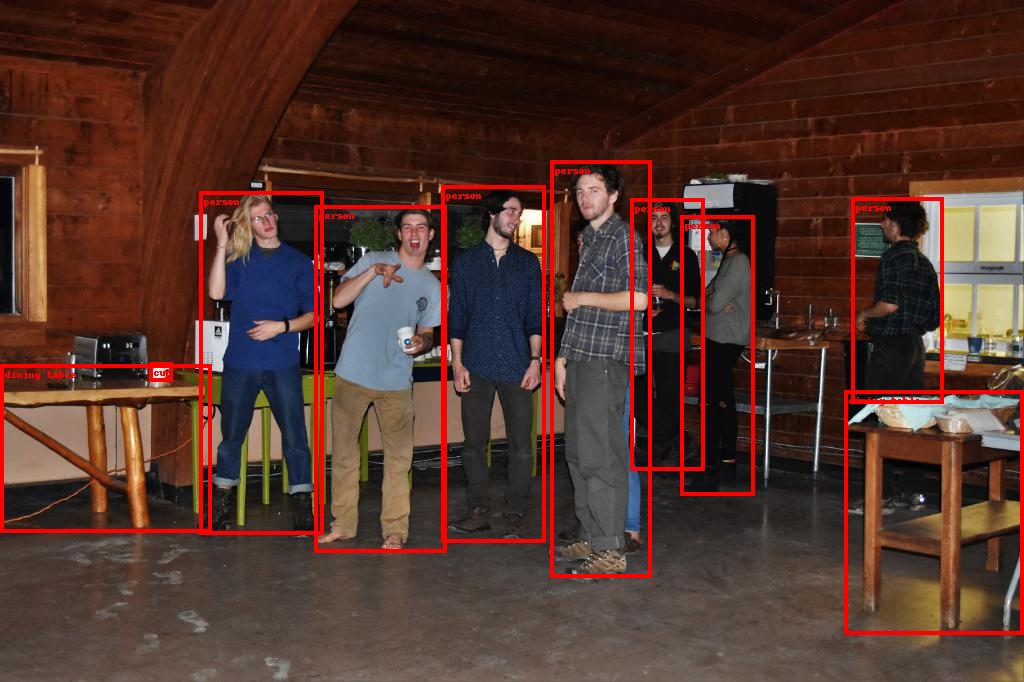

In [13]:
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

img = read_image("/kaggle/input/open-images-object-detection-rvc-2020/test/b5d912e06f74e948.jpg")

# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()


# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)
im = to_pil_image(box.detach())
im

In [4]:
prediction

{'boxes': tensor([[381.4998, 425.7214, 742.6849, 691.1975],
         [243.9757, 347.5878, 347.3600, 607.6532],
         [507.5053, 215.8449, 618.8832, 424.9684],
         [292.1230, 237.9877, 362.7630, 412.3571],
         [462.2601, 430.9530, 573.0172, 678.4326],
         [800.9495, 213.1770, 861.6227, 386.5379],
         [137.9939, 384.1308, 265.4213, 416.7125]], grad_fn=<StackBackward0>),
 'labels': tensor([1, 1, 1, 1, 1, 1, 3]),
 'scores': tensor([0.9988, 0.9986, 0.9976, 0.9672, 0.9662, 0.9652, 0.9336],
        grad_fn=<IndexBackward0>)}

In [5]:
import pandas as pd
path1='/kaggle/input/open-images-object-detection-rvc-2020/test/'
sample = pd.read_csv("/kaggle/input/open-images-object-detection-rvc-2020/sample_submission.csv")
sample.head()

,ImageId,PredictionString
0,b5d912e06f74e948,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
1,be137cf6bb0b62d5,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
2,8d65ca08cb5ce8e8,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
3,4d3ad1e52ad8c065,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...
4,9b94408691c7d7bf,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()


model = model.to(device)

In [30]:
in_path = "/kaggle/input/open-images-object-detection-rvc-2020/test/"
from torch.utils.data import Dataset, DataLoader

class myDataset(Dataset):
    def __init__(self, in_path):
        super().__init__()
        self.in_path = in_path
        self.jpgs = sample['ImageId'].tolist()
        self.preprocess = weights.transforms()
    def __getitem__(self, idx):
        return preprocess(read_image(self.in_path+'/'+self.jpgs[idx]+'.jpg')), self.jpgs[idx]
    def __len__(self):
        return len(self.jpgs)

dst = myDataset(in_path)
loader = DataLoader(dst, batch_size=1)

In [45]:
names = weights.meta['categories']
for x, imageId in loader:
    x, imageId = x.to(device), imageId[0]
    result = model(batch)[0]
    prediction_strings = []
    for i in range(len(result['scores'])):
        class_name = names[i].encode("utf-8").decode("utf-8")
        YMin,XMin,YMax,XMax = result['boxes'][i]
        score = result['scores'][i]

        prediction_strings.append(
            f"{class_name} {score} {XMin} {YMin} {XMax} {YMax}"
        )
    display(imageId)
    prediction_string = " ".join(prediction_strings)
    display(sample.loc[sample['ImageId']==imageId])
    sample.loc[sample['ImageId']==imageId, ['PredictionString']] = prediction_string
    display(prediction_string)
    display(sample.loc[sample['ImageId']==imageId])
    break

'b5d912e06f74e948'

,ImageId,PredictionString
0,b5d912e06f74e948,__background__ 0.9996857643127441 205.93756103...


'__background__ 0.9996857643127441 205.93756103515625 314.4111633300781 552.9757690429688 446.2165832519531 person 0.9994651675224304 185.1414794921875 441.3690490722656 542.0123901367188 545.6600952148438 bicycle 0.9994070529937744 191.56443786621094 199.14337158203125 534.9468994140625 323.15386962890625 car 0.9980528354644775 197.2604522705078 851.9246826171875 403.0540466308594 943.954833984375 motorcycle 0.9978405237197876 160.0160369873047 550.96728515625 577.1727905273438 651.9701538085938 airplane 0.9971350431442261 362.31451416015625 149.32508850097656 381.14202880859375 172.1710205078125 bus 0.9947147965431213 198.91925048828125 630.799560546875 470.9226379394531 704.1692504882812 train 0.9875213503837585 215.18846130371094 680.1406860351562 495.6184997558594 754.7407836914062 truck 0.9547236561775208 364.3043518066406 0.1912013441324234 532.1740112304688 211.84408569335938 boat 0.9147025346755981 390.132568359375 844.4248046875 634.2769775390625 1023.8056640625'

,ImageId,PredictionString
0,b5d912e06f74e948,__background__ 0.9996857643127441 205.93756103...
